## Solving the Climate Crisis with Text Mining
### Economics and Politicians on Twitter

### Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

#basic packages 
import pandas as pd
from sklearn.model_selection import train_test_split

#utility packages
from utils.preprocessing import preprocess_tweets
from utils.data_loader import load_tweets
from utils.sampler import shrink_major_class_down, oversample
from utils.textfile_creator import create_txt_file
from utils.class_extractor import extract_classes
from utils.labeling import load_labelled_tweets

#bert Models
from Bert_models.language_model.language_model import BertLanguageModel
from Bert_models.classification_model.classification_model import BertClassificationModel
from Bert_models.embeddings_by_Bert.embeddings import BertEmbeddings

#knowledge retrieval
from visualization.visualize import visualize_embeddings
from utils.clusters import find_clusters

#tokenizer
from tokenizer.tokenizer import build_tokenizer, test_tokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


### Load Data

The tweet data of the Mercator Research Institute on Global Commons and Climate Change will be loaded.

In [2]:
all_data_tweets=load_tweets()

tweet data is already saved. Loading ...
done


In [3]:
data = all_data_tweets
data.head()

0    Paradoxer Effekt: Warum die Erderwärmung für e...
1    Kühleffekt: Grüne Wiesen als Mittel gegen die ...
2    Klimaforschung: Bis zu sechs Grad Erderwärmung...
3    Auch wenn im Moment der Eindruck anders ist: G...
4    Erderwärmung: Britisches Institut veröffentlic...
Name: text, dtype: object

### Preprocess Data

Cleaning and pre-processing the dataset 

In [4]:
tweets_preprocessed=preprocess_tweets(data)

tweets are already preprocessed. Loading ...
done


### Bert Language model

In [5]:
#configurations
pretrained_weigths='bert-base-german-cased'
model_path="./saved_states/MCC_Bert_LanguageModel/"   ##model will be sent on request
data_sample_path="./saved_states/test.txt"
checkpoint_path="./saved_states/MCC_Bert_Test"
save_path="./saved_states/Bert_Language_Model"

In [6]:
#a small sample of tweets to illustrate that our functions work.
tweet_chunk=tweets_preprocessed[1600000:1600000+50]

In [7]:
#creating a small sample text file to illustrate that our language model training work.
create_txt_file(tweet_chunk,"./saved_states/test.txt")

In [8]:
#initialization of the model
model= BertLanguageModel(pretrained_weigths,model_path)

In [9]:
#model training based on file path
model.fit(file_path=data_sample_path,
          checkpoint_path=checkpoint_path,
          save_path=save_path)

In [10]:
#test training based on small data chunk
model.fit(file_path=data_sample_path,
          checkpoint_path=checkpoint_path,
          save_path=save_path,
          tweets=tweet_chunk)

In [11]:
#let the model predict one masked word
model.predict("Das Projekt bekommt eine [MASK] Note.")

gute


### Bert Classification Model

In [39]:
#configurations
path_to_labelled_data="./saved_states/labelled_data_preprocessed.pkl" 
pretrained_weigths='bert-base-german-cased'
model_path="./saved_states/MCC_Bert_ClassificationModel/"  #model will be sent on request

In [13]:
#load and preprocess labelled data
labelled_data=pd.read_pickle(path_to_labelled_data, compression="bz2")
labelled_data.text=labelled_data.text[labelled_data.text.notnull()]
labelled_data.dropna(inplace=True)
labelled_data=labelled_data.reset_index(drop=True)
labelled_data.label.value_counts()

None          206925
industry        3387
politician       961
news             345
Name: label, dtype: int64

In [14]:
#get pure datasets
industry_data, polit_data, news_data= extract_classes(labelled_data)

In [15]:
#factorize labels
labelled_data.label = pd.Categorical(pd.factorize(labelled_data.label)[0])

In [16]:
#reduction of the largest category to 10000 samples
labelled_data_prep=shrink_major_class_down(labelled_data,number_to_be_shrinked=10000)
labelled_data_prep.label.value_counts()

0    10000
1     3387
2      961
3      345
Name: label, dtype: int64

In [17]:
#splitting the data into a training and a test set
data_train_under, data_test_under = train_test_split(labelled_data_prep, test_size=0.1, random_state=42,stratify=labelled_data_prep.label)

In [18]:
#oversample the 3 minor classes of the training set
labelled_data_prep=oversample(labelled_data_prep)
labelled_data_prep.label.value_counts()

3    10000
2    10000
1    10000
0    10000
Name: label, dtype: int64

#### Classifier training

In [19]:
#splitting the balanced data into a training and a test set
data_train, data_test = train_test_split(labelled_data_prep, test_size=0.1, random_state=42,stratify=labelled_data_prep.label)

In [20]:
#two small samples of tweets to illustrate that our classification model training works
data_train_small=data_train[0:20]
data_test_small=data_test[0:20]

In [40]:
#initialization of the model
model=BertClassificationModel(key_for_vocab=pretrained_weigths,model_path=model_path,num_labels=len(labelled_data.label.unique()),show_parameter=True)

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [22]:
#model training and evaluation based on sample chunks
model.fit(data_train=data_train_small,data_test=data_test_small, save_path="./saved_states/")


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.76
  Training epoch took: 0:00:05

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.49
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.36
  Training epoch took: 0:00:06

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.57
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.76
  Training epoch took: 0:00:06

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.45
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.07
  Training epoch took: 0:00:06

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.39
  Validation took: 0:00:01

Training complete!
Total training took 0:00:28 (h:mm:ss)


In [42]:
#let the model predict the label of a tweet
model.predict("Liebe Mitbürgerinnen und Mitbürger, Teile dieser Antwort könnten Sie verunsichern.")

Liebe Mitbürgerinnen und Mitbürger, Teile dieser Antwort könnten Sie verunsichern.

Dieser Tweet kann politician zugeordnet werden


'politician'

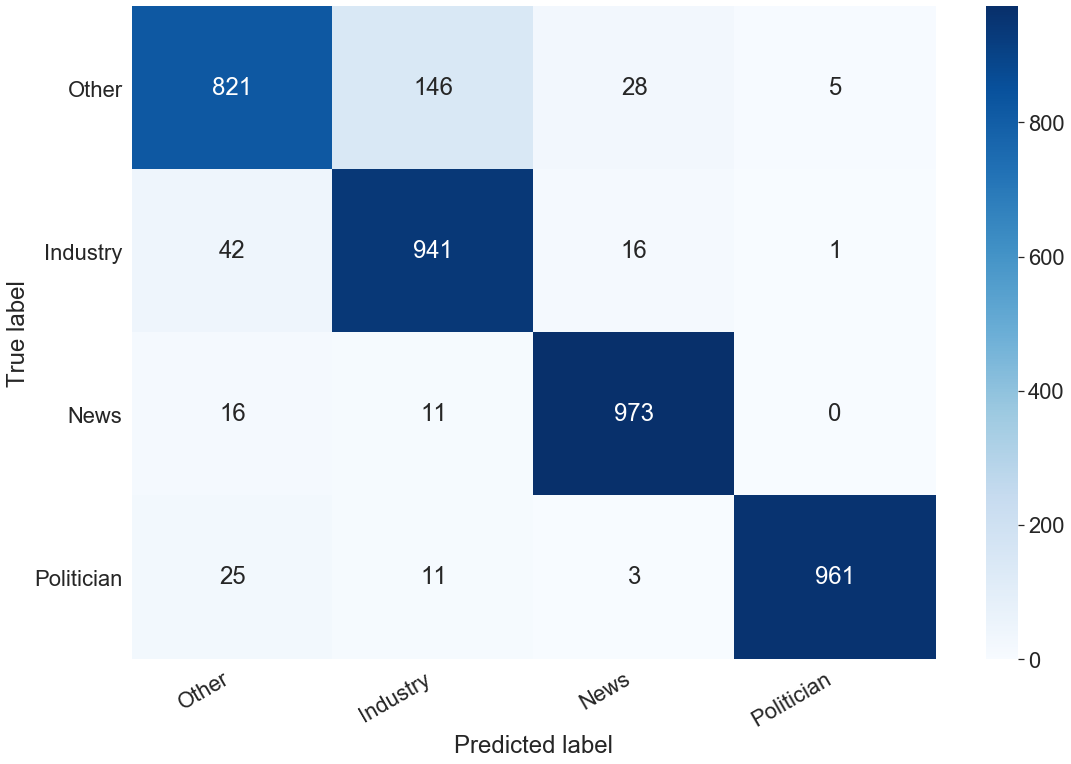

In [24]:
#visualization of the model performance on test data
model.confusion_matrix(data_test) 

### Bert Embeddings

In [25]:
#configurations
pretrained_weigths='bert-base-german-cased'
model_path="./saved_states/MCC_Bert_ClassificationModel/"  #model will be sent on request

In [26]:
#two samples of tweets to illustrate that our embedding approach works
tweets_preprocessed_train=data_train_under
tweets_preprocessed_test=data_test_under 

#small sample of tweets to illustrate that our embedding approach works
tweets_preprocessed_test_small=tweets_preprocessed_test[:20]

In [27]:
#initialization of the model
model = BertEmbeddings(key_for_vocab=pretrained_weigths,model_path=model_path)

In [28]:
#model embedds the sample chunk
embeddings=model.embedd(tweets=tweets_preprocessed_test.text,save_path="./saved_states/saved_embeddings")
embeddings.head()


Creating Embeddings...
  Batch    40  of  1,470.    Elapsed: 0:00:03.
  Batch    80  of  1,470.    Elapsed: 0:00:07.
  Batch   120  of  1,470.    Elapsed: 0:00:10.
  Batch   160  of  1,470.    Elapsed: 0:00:13.
  Batch   200  of  1,470.    Elapsed: 0:00:16.
  Batch   240  of  1,470.    Elapsed: 0:00:20.
  Batch   280  of  1,470.    Elapsed: 0:00:23.
  Batch   320  of  1,470.    Elapsed: 0:00:26.
  Batch   360  of  1,470.    Elapsed: 0:00:30.
  Batch   400  of  1,470.    Elapsed: 0:00:33.
  Batch   440  of  1,470.    Elapsed: 0:00:36.
  Batch   480  of  1,470.    Elapsed: 0:00:40.
  Batch   520  of  1,470.    Elapsed: 0:00:43.
  Batch   560  of  1,470.    Elapsed: 0:00:46.
  Batch   600  of  1,470.    Elapsed: 0:00:50.
  Batch   640  of  1,470.    Elapsed: 0:00:53.
  Batch   680  of  1,470.    Elapsed: 0:00:56.
  Batch   720  of  1,470.    Elapsed: 0:01:00.
  Batch   760  of  1,470.    Elapsed: 0:01:03.
  Batch   800  of  1,470.    Elapsed: 0:01:07.
  Batch   840  of  1,470.    Elapsed

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.155501,0.618788,-0.400000,-0.168723,0.099905,-0.115501,-0.065136,-0.380747,-0.082125,0.337148,...,0.303687,-0.384173,-0.500934,-0.123788,0.121741,-0.414208,-0.782178,-0.024209,0.094186,0.265898
1,-0.266550,0.433313,0.099104,-1.647289,-0.373546,1.046514,0.044095,-0.113599,-0.778936,0.667118,...,0.433179,-0.630157,-0.815644,0.206477,-1.348451,0.192473,-0.635558,1.342581,-1.088300,-0.113335
2,-0.348069,0.501527,-0.248647,0.060816,1.034725,-0.657848,-0.350031,0.143902,0.608053,-0.077793,...,0.829256,0.070150,-0.498442,0.094786,-0.312061,0.294482,-0.638179,0.169126,-0.722636,0.687678
3,0.186601,0.809216,-0.788655,0.169247,0.409595,-0.143602,-0.307500,-1.326206,0.044464,0.468244,...,0.683296,-0.148403,-0.593282,-0.850846,0.420189,-0.234947,-0.938067,0.564284,0.848563,-0.112115
4,-0.269941,0.078372,-0.210038,-0.320400,1.306775,-0.417874,-0.168585,0.313407,0.467916,-0.227055,...,0.525564,0.271849,-0.474960,-0.399733,-0.091125,0.316234,-0.244165,-0.191409,-0.364475,0.681087


#### Visualize

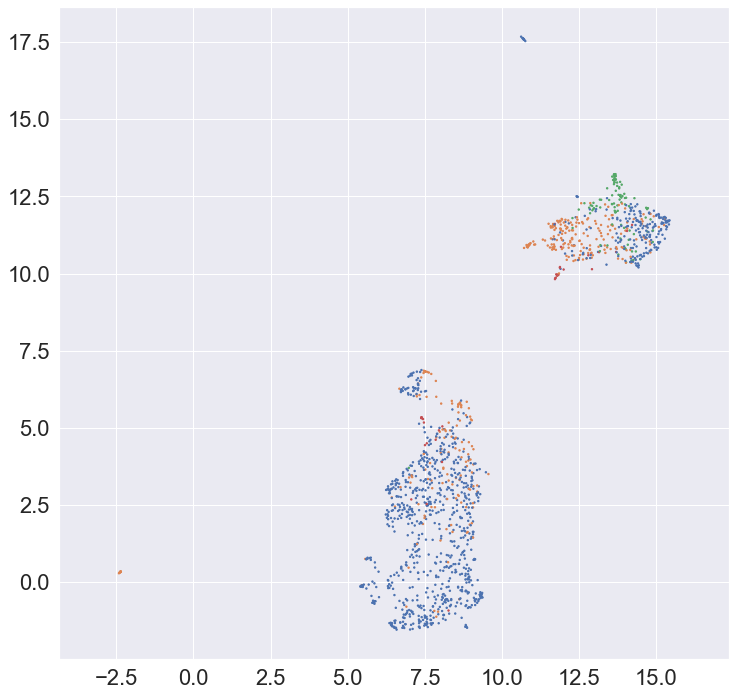

In [29]:
#visualize the embeddings using umap
reducer=visualize_embeddings()
reducer.fit(embeddings)
reducer.show(embeddings,tweets_preprocessed_test.label)

In [30]:
#using the HDBScan algorithm in combination with a PCA and umap to find clusters in the embeddings
find_clusters(embeddings,min_cluster_size=2)

array([138, 132,  -1, ..., 161, 175,   0])

### Addition

#### Create your custom tokenizer

In [31]:
#create a sample word corpus
create_txt_file(tweets=data_train.text,save_path="./saved_states/dummy_file.txt")

In [32]:
#build the tokenizer
build_tokenizer(data_path="./saved_states/dummy_file.txt",save_path="./saved_states/")

In [33]:
#test the tokenizer
test_tokenizer(test_sentence="Hi MCC, we hope you like our work",vocab_path="./saved_states/vocab.json",merge_path="./saved_states/merges.txt")

Original sentence Hi MCC, we hope you like our work
Encoded string: ['<s>', 'Hi', 'ĠMCC', ',', 'Ġwe', 'Ġhope', 'Ġyou', 'Ġlike', 'Ġour', 'Ġwork', '</s>']
Decoded string: <s>Hi MCC, we hope you like our work</s>
